In [ ]:
# Notebook written by Ryan Prasad
# GEOG 480 Fall 2 2021
# 11/25/2021
# rhprasad@outlook.com

# Final Project Part 1
# Task: Given a DEM and LandSat images, quantitize the water in the images.
# Remarks: 
# - This is a fantastic exercise that I made needlessly difficult! Kudos to Karen. This is far more involved than what am writing for 483.
# - These are the results I am submitting for grading and will update this document upon being graded.
# - This is my first deep dive into ArcGIS Notebooks
# - Someone who has completed the Codecademy Python course should be able to script this workflow. The limiting factor is time.

In [ ]:
# Geog 480: Exploring Imagery and Elevation Data in GIS Applications
# Author: Karen Schuckman, kschuckman@psu.edu
# Last Updated: 5/10/2019 6:25:00 PM Page 1 of 4
# Final Project
# (100 points)

# The final project is an opportunity to use the data processing and analysis skills that you have
# learned through the course to use in two problem-solving scenarios. You will be given, or asked
# to download, a few additional datasets, but you will also be using data from weekly lessons. You
# will be asked to produce analysis products, but not given specific instructions on how to do so.
# You will be using tools and methods you have used before. You should be creative and thoughtful
# about the presentation of your results in a way that demonstrates a thorough understand of the
# application of these tools and methods.

# There are two parts to the final project; each worth 50 points. The scoring rubric is described at
# the end of these instructions.

# Part 1: Quantifying Variations in Lake Area in Central PA using Landsat Imagery (50
# points)

# Scenario
# You have been asked to report on the variation in the amount of water land cover over a 31-year
# period, from 1982 to 2013, in a defined area of interest in central PA that you have been studying
# in this course. You have been asked to relate the overall variation in water land cover within the
# study region to the areal extent of 4 major lakes in this region over the same time period.
# The four lakes are:
# • Raystown Lake
# • Black Moshannon Lake
# • Sayers Reservoir in Bald Eagle State Park
# • Colyer Lake
# The temporal analysis is to be done using the following Landsat datasets:
# • 1982 November 25 Landsat 4
# • 1988 October 16 Landsat 5
# • 1999 October 07 Landsat 7
# • 2002 September 13 Landsat 7
# • 2013 October 21 Landsat 8
# These dates have been chosen in order to minimize the influence of normal seasonal variation in
# lake area on the temporal analysis.

# Methodology
# Your client has seen an example of your earlier work and has agreed to the use of 10-Class Iso
# Cluster unsupervised classification, provided you refine these results using the same image
# processing techniques and terrain analysis criterion, namely:
# • Slope < 2 degrees
# • Majority Filter
# • Boundary Clean

# Analysis
# As the primary output for the report, you have been asked to produce graphs or charts of your
# own design showing:
# • Temporal change in total water land cover from 1982 – 2013, in acres.
# • Temporal change in lake area for each of the 4 lakes individually from 1982 – 2013, in
# acres.
# You are to evaluate the trends in lake size to the overall trends in water land cover; for example,
# does the largest lake area occur in the year when the overall water land cover area is largest and
# does the smallest lake area occur in the year when the overall water land cover is smallest.
# In cases where an individual lake area trend does not follow the overall trend, you are asked to
# pose potential explanations based on research and local knowledge. The study region is small
# enough to assume that seasonal rainfall can be considered uniform throughout.

# Bring in the Data

In [2]:
# Landsat images from USGS Earth Explorer.

import arcpy.mp

aprx = arcpy.mp.ArcGISProject("Current")
map = aprx.listMaps()[0]

# Bring in the LandSat images
map.addDataFromPath(r'C:\Geog480Root\Final\Data\LT04_L1TP_016032_19821125_20161004_01_T1.tif')
map.addDataFromPath(r'C:\Geog480Root\Final\Data\LT05_L1TP_016032_19881016_20161002_01_T1.tif')
map.addDataFromPath(r'C:\Geog480Root\Final\Data\LE07_L1TP_016032_19991007_20161002_01_T1.tif')
map.addDataFromPath(r'C:\Geog480Root\Final\Data\LE07_L1TP_016032_20020913_20160928_01_T1.tif')
map.addDataFromPath(r'C:\Geog480Root\Final\Data\LC08_L1TP_016032_20131021_20170308_01_T1.tif')

# Bring in the project DEM
map.addDataFromPath(r'C:\Geog480Root\Final\Data\USGSDEM.img')



# Using the DEM from lesson 8, generate water rasters per instructions

In [17]:
from arcpy.sa import *

# Run the slope tool on the DEM
outSlope = Slope('USGSDEM.img', 'DEGREE', 1)

# Grab slopes < 2 degrees
outTest = Test(outSlope, "VALUE < 2")



In [18]:
from arcpy.sa import *

images = [
    "LC08_L1TP_016032_20131021_20170308_01_T1.tif",
    "LE07_L1TP_016032_20020913_20160928_01_T1.tif", 
    "LE07_L1TP_016032_19991007_20161002_01_T1.tif",
    "LT05_L1TP_016032_19881016_20161002_01_T1.tif",
    "LT04_L1TP_016032_19821125_20161004_01_T1.tif"
]


for image in images: 

    isoClasses = [[1,0],[2,0],[3,0],[4,0],[5,0],[6,0],[7,0],[8,0],[9,0],[10,0]]
    
    # Run the ISO Classification on the image
    outUnsupervised = IsoClusterUnsupervisedClassification(image, 10)
    
    # Grab the class number of water, save it as an integer
    waterClass = arcpy.GetCellValue_management(outUnsupervised, "233763.76 4472407.49") # This coordinate is in the middle of Raystown Lake
    waterClassInt = int(waterClass.getOutput(0))
    
    # Update isoClasses to indicate which class is water
    for isoClass in isoClasses:
        if isoClass[0] == waterClassInt:
            isoClass[1] = 1

    # Run the reclassify tool given the water class
    outReclass = Reclassify(outUnsupervised, "Value", RemapValue(isoClasses))
    
    # Majority Filter & Boundary Clean
    outMajFilt = MajorityFilter(outReclass)
    outBndCln = BoundaryClean(outMajFilt)

    # Multiply flatwater by the reclassified later
    outTimes = Times(outBndCln, outTest)
    outTimes.save("C:/Geog480Root/Final/Data/Rasters/{}.tif".format(image[17:21]))



# Do the analysis - quantitize water over the entire study area, then drill down on the specified lakes

[1982, 1988, 1999, 2002, 2013]
[14337, 10660, 14161, 13623, 12310]


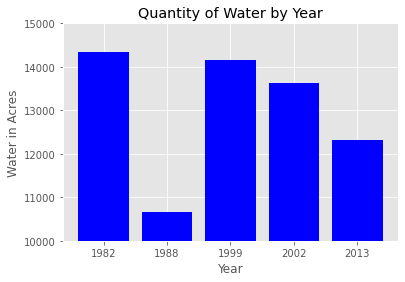

In [21]:
# Get the total acreage of water from the five rasters. Then plot them on a bar chart.

# The quantity of water is in the attribute table of the 5 rasters, which were generated from
# unsupervised classification in the previous steps. This value needs to be converted to acres from meters.
# Landsat images have a 30m ground sample distance.

# Store these in a list, then feed that along with another list containing
# the years into matplotlib for a basic bar chart.

import arcpy
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

years = [1982, 1988, 1999, 2002, 2013]
acres = []

for year in years:         
    with arcpy.da.SearchCursor("{}.tif".format(str(year)), "COUNT", "VALUE = 1") as cursor:
        for row in cursor:
            acres.append(math.trunc((row[0] * 30 * 30) / 4046.86))

x_pos = [i for i, _ in enumerate(years)]

plt.bar(x_pos, acres, color='blue')
plt.xlabel("Year")
plt.ylabel("Water in Acres")
plt.title("Quantity of Water by Year")
plt.ylim(10000, 15000)
plt.xticks(x_pos, years)

print(years)
print(acres)

plt.show()



In [22]:
# Create polygons of the lakes using the raster to polygon tool for each of the year.
# The output will be 5 shp files for the 5 years. 

import arcpy
from arcpy import env
env.workspace = r"C:\Geog480Root\Final\Data\Rasters"

for year in years:
    arcpy.conversion.RasterToPolygon(in_raster = "{}.tif".format(year), 
                                     out_polygon_features = "C:/Geog480Root/Final/Data/Polygons/{}.shp".format(year),
                                     simplify = True,
                                     create_multipart_features = False)
    
    

In [1]:
# 4 lakes of interest: Raystown Lake, Black Moshannon Lake, Sayers Reservoir, Colyer Lake
# Manually cleaned up the lake polygons prior to this step. Only the shapes of the 4 lakes remain for analysis.
# Calculate the area of the 4 lakes. The results will be reflected in the attribute table.
# If this cell does not run due to a table being in use, restart ArcGIS Pro

import arcpy
from arcpy import env
env.workspace = "C:/Geog480Root/Final/Data/Polygons"

years = [1982, 1988, 1999, 2002, 2013]

for year in years:
    arcpy.management.AddGeometryAttributes(Input_Features = ("{}.shp".format(year)),
                                                 Geometry_Properties = "AREA",
                                                 Area_Unit = "ACRES")
    
    

[1982, 1988, 1999, 2002, 2013]
[8450, 7475, 8715, 8727, 8500]


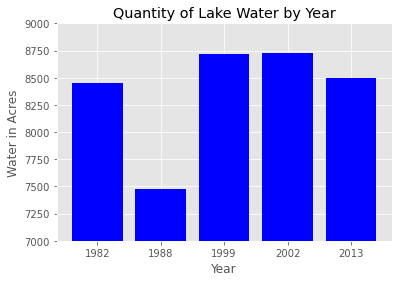

In [3]:
# Sum the areas in the attribute tables, add them to a list, print out the list, plot them in matplotlib
# Areas are already in acres

import arcpy
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

lake_area = []

for year in years:         
    with arcpy.da.SearchCursor(in_table = ("{}.shp".format(year)), field_names = "POLY_AREA") as cursor:
        
        area_holder = 0 # counter variable that resets to 0 when moving on to the next year
        
        for row in cursor:
            area_holder += math.trunc(row[0])

        lake_area.append(area_holder)    

print(years)
print(lake_area)

x_pos = [i for i, _ in enumerate(years)]

plt.bar(x_pos, lake_area, color='blue')
plt.xlabel("Year")
plt.ylabel("Water in Acres")
plt.title("Quantity of Lake Water by Year")
plt.ylim(7000, 9000)
plt.xticks(x_pos, years)

plt.show()



# Going above and beyond: Is there any variation? The answer is no.

In [4]:
# Run the workflow 10 times to see if there is any variation in the 2013 image.
# There is no variation in the pixels of water which makes sense,
# since the image has not changed. Just wanted to make sure this was the case! ;-)

from arcpy.sa import *
import time

results = []

# Flatten the water for shadows
outSlope = Slope('USGSDEM.img', 'DEGREE', 1)
outTest = Test(outSlope, "VALUE < 2")

# Run this 10 times:
for _ in range(10):
    
    isoClasses = [[1,0],[2,0],[3,0],[4,0],[5,0],[6,0],[7,0],[8,0],[9,0],[10,0]]

    # Run the ISO Classification on the image
    outUnsupervised = IsoClusterUnsupervisedClassification("LC08_L1TP_016032_20131021_20170308_01_T1.tif", 10)
    
    # Grab the class number of water
    waterClass = arcpy.GetCellValue_management(outUnsupervised, "233763.76 4472407.49")
    waterClassInt = int(waterClass.getOutput(0))
    
    # Update isoClasses to indicate which class is water
    for isoClass in isoClasses:
        if isoClass[0] == waterClassInt:
            isoClass[1] = 1

    # Run the reclassify tool given the water class
    outReclass = Reclassify(outUnsupervised, "Value", RemapValue(isoClasses))
    outMajFilt = MajorityFilter(outReclass)
    outBndCln = BoundaryClean(outMajFilt)

    # Multiply flatwater by the reclassified later
    outTimes = Times(outBndCln, outTest)
    outTimes.save("C:/Geog480Root/Final/Data/outTimes.tif")

    # Grab the acreage from the attribute table
    with arcpy.da.SearchCursor("C:/Geog480Root/Final/Data/outTimes.tif", "COUNT", "VALUE = 1") as cursor:
        for row in cursor:
            pixels = row[0]

    # Append result to list
    results.append(pixels)
    
print(results)



[55356.0, 55356.0, 55356.0, 55356.0, 55356.0, 55356.0, 55356.0, 55356.0, 55356.0, 55356.0]
